<a href="https://colab.research.google.com/github/mpgl/dendrify-paper/blob/main/Figure_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Install dependencies
!pip install brian2 --quiet

!rm -rf dendrify-paper
!git clone https://github.com/mpgl/dendrify-paper.git

import os
os.chdir('dendrify-paper')

Cloning into 'dendrify-paper'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 45 (delta 15), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (45/45), done.


In [2]:
# Imports and setup
import brian2 as b
from brian2.units import (ms, um, pA, nS, uS, ohm, cm, mV, uF, mvolt) # Generally a better practise than * import
from dendrify import Soma, Dendrite, NeuronModel
import matplotlib.pyplot as plt
b.prefs.codegen.target = 'numpy' # Improves performance significantly here

In [3]:
# @title Figure settings
params = {"font.family": "Arial",
          "legend.fontsize": 10,
          "legend.handlelength": 1.5,
          "legend.edgecolor": 'inherit',
          "legend.columnspacing": 0.8,
          "legend.handletextpad": 0.5,
          "axes.labelsize": 10,
          "axes.titlesize": 11, 
          "axes.spines.right": False,
          "axes.spines.top": False,
          "axes.edgecolor": "#d3d3d3",
          "xtick.color": '#d3d3d3',
          "xtick.labelsize": 10,
          "ytick.color": '#d3d3d3',
          "ytick.labelsize": 10,
          'mathtext.default': 'regular',
          'lines.markersize': 3,
          'lines.linewidth': 1.25,
          'grid.linestyle': ":",
          'grid.color': "#d3d3d3",
          'text.antialiased': True,
          'lines.antialiased': True,
          'figure.dpi': 400
          }
          
graphite = "#4B4E53"
blue = '#005c94ff'
green = '#338000ff'
orange = '#ff6600ff'
notred = '#aa0044ff'
dsblue = '#0BA8E6'
light_gray = "#b5b5b5"

plt.rcParams.update(params)
%matplotlib inline

***Let's first build a basic 3-compartment model with passive dendrites:***

In [4]:
# create soma
soma = Soma('soma', model='leakyIF', length=25*um, diameter=25*um)

# create apical dendrite
apical = Dendrite('apical', length=250*um, diameter=2*um)

# create basal dendrite
basal = Dendrite('basal', length=150*um, diameter=2*um)

# add noise
apical.noise(tau=20*ms, sigma=3*pA, mean=0*pA)
basal.noise(tau=20*ms, sigma=3*pA, mean=0*pA)

# add synapses
apical.synapse('AMPA', pre='cortex', g=1*nS, t_decay=2*ms)
apical.synapse('NMDA', pre='cortex', g=1*nS, t_decay=60*ms)

# merge compartments into a  neuron model and set its properties
edges = [(soma, apical, 10*nS), (soma, basal, 10*nS)]
pyr_model = NeuronModel(edges, cm=1*uF/(cm**2), gl=50*uS/(cm**2),
                          v_rest=-70*mV, r_axial=150*ohm*cm,
                          scale_factor=3, spine_factor=1.5)

# create a Brian NeuronGroup and link it to the neuron model
pyr_group = b.NeuronGroup(3, model=pyr_model.equations, method='euler',
                          threshold='V_soma > -40*mV', reset='V_soma = -50*mV',
                          refractory=3*ms, namespace=pyr_model.parameters)
pyr_model.link(pyr_group)

***We can inspect what Dendrify created for us simply by printing a NeuronModel object:***

In [5]:
print(pyr_model)

OBJECT TYPE:

  <class 'dendrify.neuronmodel.NeuronModel'>

---------------------------------------------

PROPERTIES (type): 

→ equations (str):
    dV_soma/dt = (gL_soma * (EL_soma-V_soma) + I_soma) / C_soma  :volt
    I_soma = I_ext_soma + I_basal_soma  + I_apical_soma   :amp
    I_ext_soma  :amp
    I_apical_soma = (V_apical-V_soma) * g_apical_soma  :amp
    I_basal_soma = (V_basal-V_soma) * g_basal_soma  :amp
    
    dV_apical/dt = (gL_apical * (EL_apical-V_apical) + I_apical) / C_apical  :volt
    I_apical = I_ext_apical + I_soma_apical  + I_NMDA_cortex_apical + I_AMPA_cortex_apical + I_noise_apical  :amp
    I_ext_apical  :amp
    dI_noise_apical/dt = (mean_noise_apical-I_noise_apical) / tau_noise_apical + sigma_noise_apical * (sqrt(2/tau_noise_apical) * xi_apical) :amp
    I_AMPA_cortex_apical = g_AMPA_cortex_apical * (E_AMPA-V_apical) * s_AMPA_cortex_apical * w_AMPA_cortex_apical  :amp
    ds_AMPA_cortex_apical/dt = -s_AMPA_cortex_apical / t_AMPA_decay_cortex_apical  :1
    

***Also we can access any of its properties using the dot notation (example:):***


In [6]:
pyr_model.parameters

{'C_apical': 70.68583471 * pfarad,
 'C_basal': 42.41150082 * pfarad,
 'C_soma': 58.90486225 * pfarad,
 'EL_apical': -70. * mvolt,
 'EL_basal': -70. * mvolt,
 'EL_soma': -70. * mvolt,
 'E_AMPA': 0. * volt,
 'E_Ca': 136. * mvolt,
 'E_GABA': -80. * mvolt,
 'E_K': -90. * mvolt,
 'E_NMDA': 0. * volt,
 'E_Na': 50. * mvolt,
 'Mg': 1.0,
 'alpha': 0.062,
 'beta': 3.57,
 'gL_apical': 3.53429174 * nsiemens,
 'gL_basal': 2.12057504 * nsiemens,
 'gL_soma': 2.94524311 * nsiemens,
 'g_AMPA_cortex_apical': 1. * nsiemens,
 'g_NMDA_cortex_apical': 1. * nsiemens,
 'g_apical_soma': 10. * nsiemens,
 'g_basal_soma': 10. * nsiemens,
 'g_soma_apical': 10. * nsiemens,
 'g_soma_basal': 10. * nsiemens,
 'gamma': 0,
 'mean_noise_apical': 0. * amp,
 'mean_noise_basal': 0. * amp,
 'sigma_noise_apical': 3. * pamp,
 'sigma_noise_basal': 3. * pamp,
 't_AMPA_decay_cortex_apical': 2. * msecond,
 't_NMDA_decay_cortex_apical': 60. * msecond,
 'tau_noise_apical': 20. * msecond,
 'tau_noise_basal': 20. * msecond,
 'w_AMPA_c

***Let's replicate now the experiments of Figure 2:***

In [7]:
# Set monitors for variables of interest
M = b.StateMonitor(pyr_group, ["V_soma", "V_apical", "V_basal"], record=True)

# Run simulation
I = 100 * pA
b.run(100*ms)
pyr_group.I_ext_soma[0] = I
pyr_group.I_ext_apical[1] = I
pyr_group.I_ext_basal[2] = I
b.run(400*ms)
pyr_group.I_ext_soma[0] = 0 * pA
pyr_group.I_ext_apical[1] = 0 * pA
pyr_group.I_ext_basal[2] = 0 * pA
b.run(550*ms)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


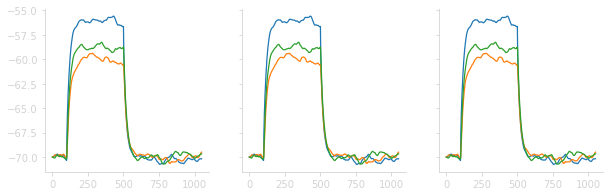

In [8]:
time = M.t/ms
vs = M.V_soma/mV
va = M.V_apical/mV
vb = M.V_basal/mV

fig, axes = plt.subplots(1, 3, figsize=[10, 3], sharex=True, sharey=True)
ax0, ax1, ax2 = axes

for i in range(3):
  ax0.plot(time, vs[i])
  ax1.plot(time, vs[i])
  ax2.plot(time, vs[i])


plt.show()

In [9]:
vs = M.V_soma/mV

In [10]:
vs

array([[-70.        , -70.        , -70.        , ..., -70.16844281,
        -70.16840281, -70.16836578],
       [-70.        , -70.        , -70.        , ..., -69.49170767,
        -69.49132101, -69.49102309],
       [-70.        , -70.        , -70.        , ..., -69.66963588,
        -69.67012557, -69.67063965]])